In [1]:
import scipy.io
import numpy.matlib as nm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import scipy

In [2]:
# Tested working on the following library versions
print(pd.__version__) #1.4.4
print(np.__version__) #1.22.4
print(scipy.__version__) #1.7.1
print(scipy.__version__) #1.7.1
!pip --version #21.2.4

2.2.2
1.26.4
1.14.1
1.14.1
pip 24.2 from c:\Users\yxh99\OneDrive\Documents\mse\.conda\Lib\site-packages\pip (python 3.12)



# Introduction

The Ni–Ti–Al dataset used for this practical is taken from: 
https://pubs.acs.org/doi/full/10.1021/acscombsci.9b00215

### Full-Width Half-Maximum (FWHM) of First Sharp Diffraction Peak (FSDP)

* Measuring the FWHM of FSDP is a commonly used method to **distinguish amorphous from crystalline alloys**
    * A thershold value for FWHM needs to be determined for proper classification
    * The threshold changes from one system to another
    
    
* The FWHM values for each Ni-Ti-Al composition is provided in the dataset!
    * Typically, this has to be extracted by fitting a Gaussian or a Lerentzian model (or a mix) to the FSDP.

<img src='img/FWHM.png' width='300' align='left' />


    

# Work flow chart

<div>
<img src="https://i.ibb.co/YZYRSLG/LR-flowchart.png]" width="500"/>
</div>

In [3]:
# #check what's in your current file directory (linux & macos)
#!ls
# # check what's in your current file directory (windows)
!dir /b

.conda
.gitignore
A1_Python_Basics.ipynb
data
dim_reduce.ipynb
E1_T1.csv
img
P3-Unsupervised_learning.ipynb
P4-Linear_regression.ipynb
Stanely_cup_winners_by_year.xlsx
test.ipynb


In [5]:
# Reading the data from the text file into pd dataframe
df = pd.read_csv('data/k20.csv', delimiter=',')
df = df.dropna(axis=1)
df

,id,x,y,Ni,Ti,Al,FWHM
0,0,-9,-30,59.982243,32.404838,7.612910,0.353388
1,1,-6,-30,55.399893,36.607529,7.992570,0.405053
2,2,-3,-30,50.655122,41.094652,8.250234,0.420897
3,3,0,-30,45.978850,45.557215,8.463945,0.454187
4,4,3,-30,41.297588,50.030058,8.672362,0.467686
...,...,...,...,...,...,...,...
357,357,0,30,13.547818,20.945231,65.506952,0.497921
358,358,3,30,12.291818,22.180581,65.527601,0.423225
359,359,6,30,11.388208,24.037212,64.574588,0.421273
360,360,9,30,10.622812,26.000906,63.376307,0.429041


In [ ]:
#pip install python-ternary  #Module needed for plotting
import ternary

def plot_ternary(data, components, z, label, title=''):
    
    fig, ax = plt.subplots()
    
    scale = 100

    grid = plt.GridSpec(10, 10, wspace=2, hspace=1)
    ax = plt.subplot(grid[:,:9])
    
    figure, tax = ternary.figure(scale=scale, ax=ax)
    # Draw Boundary and Gridlines
    tax.boundary(linewidth=2.0)
    tax.gridlines(color="blue", multiple=10)

    # Set Axis labels and Title
    fontsize = 12
    offset = 0.14
    tax.right_corner_label(components[0], fontsize=fontsize, offset=0.2, fontweight='bold')
    tax.top_corner_label(components[2], fontsize=fontsize, offset=0.23, fontweight='bold')
    tax.left_corner_label(components[1], fontsize=fontsize, offset=0.2, fontweight='bold')
    tax.left_axis_label("at.%", fontsize=fontsize, offset=offset)
    tax.right_axis_label("at.%", fontsize=fontsize, offset=offset)
    tax.bottom_axis_label("at.%", fontsize=fontsize, offset=offset)
    tax.ticks(axis='lbr', multiple=10, linewidth=1, offset=0.025, clockwise= True)
    tax.get_axes().axis('off')
    tax.clear_matplotlib_ticks()
    
    
    # Create color map and plot color bar
    cmap = plt.cm.nipy_spectral
    norm = plt.Normalize(0, z.max())
    
    tax.scatter(data, marker='o', c=cmap(norm(z)), edgecolors='k', alpha=1, s=30, vmin=z.min(), vmax=z.max())
    
    ax = plt.subplot(grid[1:-1,9:])
    cb1 = matplotlib.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, orientation='vertical', label=label)
    cb1.set_label(label=label, size=18)


source: https://github.com/marcharper/python-ternary/blob/master/README.md

In [8]:
components = ('Ni', 'Ti', 'Al')

cmp = df.loc[:,components].to_numpy()
points=nm.vstack((cmp[:,0].T,cmp[:,2].T)).T

# plot_ternary(points, components, df['FWHM'], label='FWHM $\AA^{-1}$')

### Vegard's law and Linear Regression

* Vegard's law is an empirical law that assumes that the lattice parameter (a) of an alloy can be approximated from the weighted mean of the constituents' lattice parameters. $$a_{A_{x}B_{1-x}}=x.a_A + (1-x).a_B$$

        
* We will use Linear Regression and Vegard's law to predict the FWHM (Y) of any Ni-Ti-Al alloy using the composition [e.g., X1 = comp(Ni) and X2= comp(Al) ]

$$FWHM =\beta_1.comp_{A} + \beta_2.comp_{B} + c$$

* We will use cross validation to evaluate the accuracy of the model

## Modeling

### 1. Using composition only as a feature 

Text(0, 0.5, 'FWHM')

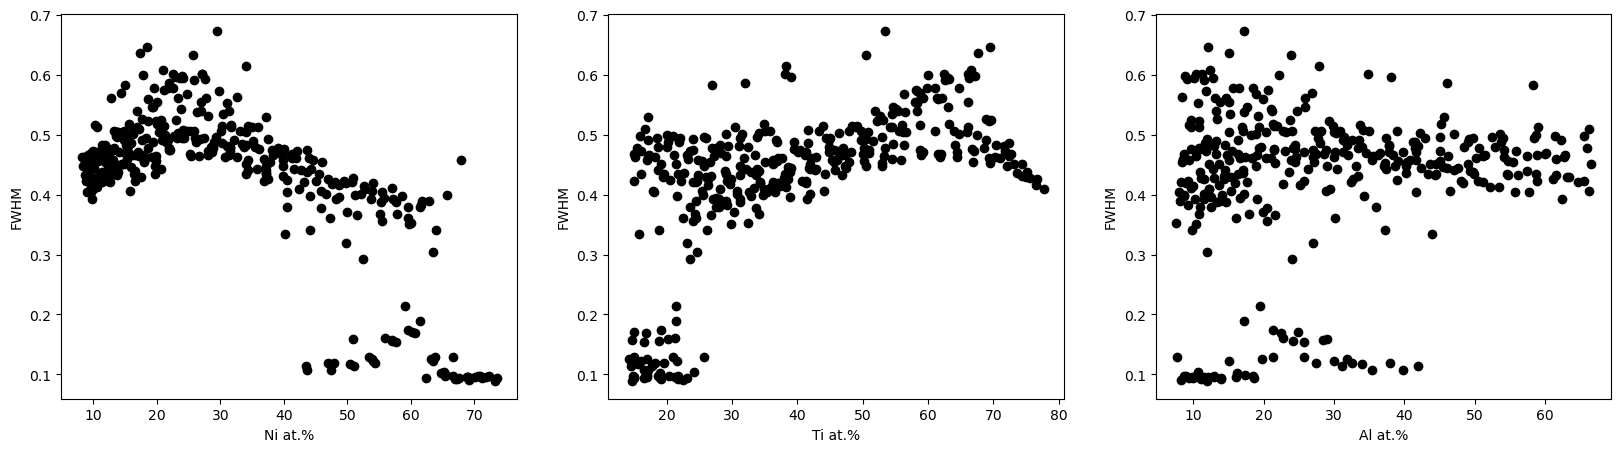

In [6]:
# plot FWHM vs composition figures to show the correlation between the composition of each element and the FWHM

plt.figure(1, figsize=(20,5))
plt.subplot(1,3,1)
plt.scatter(df['Ni'], df['FWHM'], c='k')
plt.xlabel('Ni at.%')
plt.ylabel('FWHM')

plt.subplot(1,3,2)
plt.scatter(df['Ti'], df['FWHM'], c='k')
plt.xlabel('Ti at.%')
plt.ylabel('FWHM')

plt.subplot(1,3,3)
plt.scatter(df['Al'], df['FWHM'], c='k')
plt.xlabel('Al at.%')
plt.ylabel('FWHM')


In [9]:
#correlation from dataframe

df[['Ni','Ti','Al','FWHM']].corr()

,Ni,Ti,Al,FWHM
Ni,1.000000,-0.585928,-0.487264,-0.697262
Ti,-0.585928,1.000000,-0.422151,0.584381
Al,-0.487264,-0.422151,1.000000,0.150269
FWHM,-0.697262,0.584381,0.150269,1.000000


### Ordinary Least Square (OLS) regression

The OLS method seeks to minimize the sum of the squared residuals. This means from the given data we calculate the distance from each data point to the regression line, square it, and the sum of all of the squared errors together.

![OLS](https://miro.medium.com/max/640/0*gglavDlTUWKn4Loe)

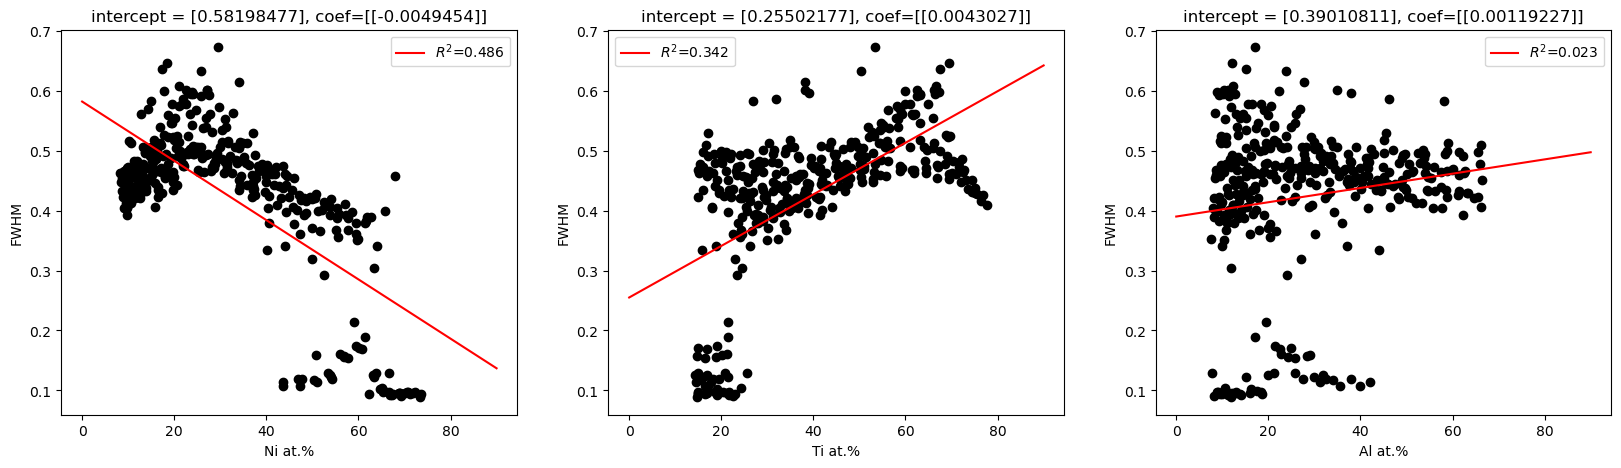

In [10]:
## Apply Ordinary Least Squares Regression on the data

from sklearn.linear_model import LinearRegression

data = df[['Ni','Ti','Al','FWHM']].to_numpy()


plt.figure(1, figsize=(20,5))
for i, element in enumerate(components):
    
    X=data[:,i][:,None]
    y=data[:,3][:,None]

    LR = LinearRegression(fit_intercept=True)
    LR.fit(X,y)

    intercept = LR.intercept_
    coef = LR.coef_
    
    xx = np.arange(0,100,10)[:,None]
    yy = LR.predict(xx)

    plt.subplot(1,3,i+1)
    plt.scatter(X, y, c='k')
    plt.plot(xx, yy, 'r', label='$R^{2}$='+ str(round(LR.score(X,y),3)))
    
    plt.xlabel(f'{element} at.%')
    plt.ylabel('FWHM')
    plt.title(f'intercept = {intercept}, coef={coef}')
    plt.legend()

### Splitting the dataset for training and testing sets
Make sure that your test set meets the following two conditions:

Is large enough to yield statistically meaningful results.
Is representative of the data set as a whole. In other words, don't pick a test set with different characteristics than the training set.

![trantestsplit](https://dhavalpatel2101992.wordpress.com/wp-content/uploads/2021/05/image-29.png?w=500)

In [11]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split 

# combining all the inputs in one array
x1= data[:,0][:,None] #Ni
x2= data[:,2][:,None] #Al
X = np.concatenate((x1,x2), axis=1)
y = data[:,3][:,None]

#splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

print('Original set ',X.shape, y.shape)
print('Training set ',X_train.shape, y_train.shape)
print('Testing set ', X_test.shape, y_test.shape)

#Trianing set
plot_ternary(X_train, components, y_train.ravel(), label='FWHM $\AA^{-1}$', title='Training set')

#Testing set
plot_ternary(X_test, components, y_test.ravel(), label='FWHM $\AA^{-1}$', title = 'Testing set')

Original set  (362, 2) (362, 1)
Training set  (217, 2) (217, 1)
Testing set  (145, 2) (145, 1)


<>:19: SyntaxWarning: invalid escape sequence '\A'
<>:22: SyntaxWarning: invalid escape sequence '\A'
<>:19: SyntaxWarning: invalid escape sequence '\A'
<>:22: SyntaxWarning: invalid escape sequence '\A'
C:\Users\yxh99\AppData\Local\Temp\ipykernel_17892\1060545408.py:19: SyntaxWarning: invalid escape sequence '\A'
  plot_ternary(X_train, components, y_train.ravel(), label='FWHM $\AA^{-1}$', title='Training set')
C:\Users\yxh99\AppData\Local\Temp\ipykernel_17892\1060545408.py:22: SyntaxWarning: invalid escape sequence '\A'
  plot_ternary(X_test, components, y_test.ravel(), label='FWHM $\AA^{-1}$', title = 'Testing set')
C:\Users\yxh99\AppData\Local\Temp\ipykernel_17892\1060545408.py:19: SyntaxWarning: invalid escape sequence '\A'
  plot_ternary(X_train, components, y_train.ravel(), label='FWHM $\AA^{-1}$', title='Training set')
C:\Users\yxh99\AppData\Local\Temp\ipykernel_17892\1060545408.py:22: SyntaxWarning: invalid escape sequence '\A'
  plot_ternary(X_test, components, y_test.ravel()

NameError: name 'plot_ternary' is not defined

In [13]:
#Use training set for model trianing
LR = LinearRegression(fit_intercept=True)
LR.fit(X_train,y_train)
intercept = LR.intercept_
coef = LR.coef_
print(f'intercept = {intercept}, coefs={coef}')
print(f'Training R^2={round(LR.score(X_train,y_train),3)}')

#Use testing set for model validation
y_hat = LR.predict(X_test)
mse = mean_squared_error(y_test, y_hat)
print(f'MSE={round(mse,5)}', f'Testing R^2={round(r2_score(y_test, y_hat),3)}')


#Plot predictions
plot_ternary(X_test, components, y_hat.ravel(), label='FWHM $\AA^{-1}$', title = 'Testing set')

intercept = [0.65967561], coefs=[[-0.00563933 -0.00193884]]
Training R^2=0.525
MSE=0.00852 Testing R^2=0.541


<>:16: SyntaxWarning: invalid escape sequence '\A'
<>:16: SyntaxWarning: invalid escape sequence '\A'
C:\Users\yxh99\AppData\Local\Temp\ipykernel_17892\93572350.py:16: SyntaxWarning: invalid escape sequence '\A'
  plot_ternary(X_test, components, y_hat.ravel(), label='FWHM $\AA^{-1}$', title = 'Testing set')
C:\Users\yxh99\AppData\Local\Temp\ipykernel_17892\93572350.py:16: SyntaxWarning: invalid escape sequence '\A'
  plot_ternary(X_test, components, y_hat.ravel(), label='FWHM $\AA^{-1}$', title = 'Testing set')


NameError: name 'plot_ternary' is not defined

In [ ]:
#Another way to visualize the predicted data vs true values
plt.scatter(np.arange(0,145,1),y_test, label='test')
plt.scatter(np.arange(0,145,1), y_hat, marker='x', c='r', label='predicted')
plt.legend(loc='best')
plt.xlabel('sample number')
plt.ylabel('FWHM')

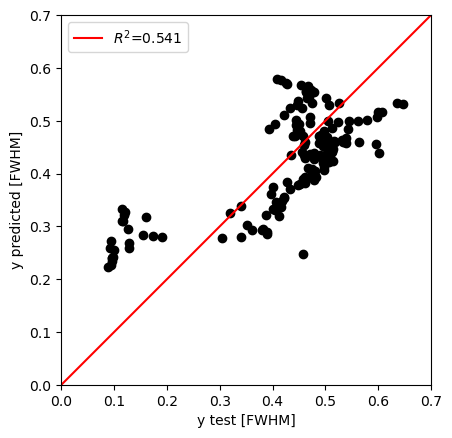

In [14]:
# Parity plot

plt.scatter(y_test, y_hat, c='k')
plt.xlabel('y test [FWHM]')
plt.ylabel('y predicted [FWHM]')


LR = LinearRegression(fit_intercept=True)
LR.fit(y_test,y_hat)

intercept = LR.intercept_
coef = LR.coef_
    
xx = np.arange(0,1,0.1)[:,None]
yy = xx

plt.plot(xx,yy, c='r', label='$R^{2}$='+ str(round(r2_score(y_test, y_hat),3)) )
plt.legend()
plt.xlim(0, 0.7)
plt.ylim(0, 0.7)
plt.gca().set_aspect('equal', adjustable='box')

### 2. Using matminer for featurizing the data 

We will use the following two features in addition to composition:
- Miedema potential 
- Yang Solid Solution


### Featurization

In [ ]:
formula = 'Ni'+df['Ni'].astype(str)+'Ti'+df['Ti'].astype(str)+'Al'+df['Al'].astype(str)
df2 = pd.DataFrame({'Formula':formula, 'FWHM':df['FWHM']})
df2

In [ ]:
# !pip install matminer

In [ ]:
from matminer.featurizers.conversions import StrToComposition

#convert the formula from a string into chemical composition
df2 = StrToComposition().featurize_dataframe(df2, "Formula")
df2.head()

In [ ]:
from matminer.featurizers.composition import Miedema

df2 = Miedema().featurize_dataframe(df2, col_id="composition")
df2.head()

In [ ]:
from matminer.featurizers.composition import YangSolidSolution

df2 = YangSolidSolution().featurize_dataframe(df2, col_id="composition")
df2.head()

### Modeling

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split 

# combining all the inputs in one array
x1= df['Ni'][:,None] #Ni
x2= df['Al'][:,None] #Al
x3= df2.loc[:, ~df2.columns.isin(['Formula','FWHM','composition'])].to_numpy() #added ~ to get the difference/inverse df

X = np.concatenate((x1,x2,x3), axis=1)
y = df['FWHM'][:,None]

In [ ]:
#splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

print('Original set ',X.shape, y.shape)
print('Training set ',X_train.shape, y_train.shape)
print('Testing set ', X_test.shape, y_test.shape)

#Trianing set
plot_ternary(X_train, components, y_train.ravel(), label='FWHM $\AA^{-1}$', title='Training set')

#Testing set
plot_ternary(X_test, components, y_test.ravel(), label='FWHM $\AA^{-1}$', title = 'Testing set')

In [ ]:
#Use training set for model trianing
LR = LinearRegression(fit_intercept=True)
LR.fit(X_train,y_train)
intercept = LR.intercept_
coef = LR.coef_
print(f'intercept = {intercept}, coefs={coef}')
print(f'Training R^2={round(LR.score(X_train,y_train),3)}')

#Use testing set for model validation
y_hat = LR.predict(X_test)
mse = mean_squared_error(y_test, y_hat)
print(f'MSE={round(mse,5)}', f'Testing R^2={round(r2_score(y_test, y_hat),3)}')


#Plot predictions
plot_ternary(X_test, components, y_hat.ravel(), label='FWHM $\AA^{-1}$', title = 'Testing set')

In [ ]:
#Another way to visualize the predicted data vs 
plt.scatter(np.arange(0,145,1),y_test, label='test')
plt.scatter(np.arange(0,145,1), y_hat, marker='x', c='r', label='predicted')
plt.legend(loc='best')
plt.xlabel('sample number')
plt.ylabel('FWHM')

In [ ]:
# Parity plot

plt.scatter(y_test, y_hat, c='k')
plt.xlabel('y test [FWHM]')
plt.ylabel('y predicted [FWHM]')


LR = LinearRegression(fit_intercept=True)
LR.fit(y_test,y_hat)

intercept = LR.intercept_
coef = LR.coef_
    
xx = np.arange(0,1,0.1)[:,None]
yy = xx

plt.plot(xx,yy, c='r', label='$R^{2}$='+ str(round(r2_score(y_test, y_hat),3)) )
plt.legend()
plt.xlim(0, 0.7)
plt.ylim(0, 0.7)
plt.gca().set_aspect('equal', adjustable='box')

## Other linear regression techniques!
1. Lasso Regression: reduces the number of inputs (L1)


2. Ridge Regression: solves multicollinearity between features (L2)


3. Mixed regression: L1+L2

<img src="img/reg.png" />

source: https://towardsdatascience.com/from-linear-regression-to-ridge-regression-the-lasso-and-the-elastic-net-4eaecaf5f7e6

In [ ]:
## Trying other regression techniques

from sklearn.linear_model import Ridge

# Ridge Regression (used when there is multicollinearity)
RR = Ridge(alpha=1e-05, fit_intercept=True)
RR.fit(X_train, y_train)
print('Ridge Regression: ',f'Training R^2={round(RR.score(X_train,y_train),3)}')
print(RR.intercept_, RR.coef_)
y_hat = RR.predict(X_test)
mse = mean_squared_error(y_test, y_hat)
print(f'MSE={round(mse,5)}', f'Testing R^2={round(r2_score(y_test, y_hat),3)}')

In [ ]:
## using Ridge CV to determine alpha value

from sklearn.linear_model import RidgeCV

RRCV = RidgeCV(alphas=[1e-6,1e-5,1e-4, 1e-3, 1e-2, 1e-1, 1], cv = 5).fit(X_train, y_train)
print(RRCV.alpha_)
print(RRCV.coef_)

### Cross Validation

<img src="img/k-fold.png" width='600'/>

https://scikit-learn.org/stable/modules/cross_validation.html

In [ ]:
from sklearn.model_selection import cross_val_score

cross_val_score(LR, X, y, cv=5, verbose=3) 